In [1]:
import json
import math
import random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from typing import List

BASE_DIR = Path('.').resolve()
OUT_DIR = BASE_DIR / 'runs'
PROC_META = BASE_DIR / 'proc' / 'processed_metadata.csv'
GLOBAL_STATS_PATH = BASE_DIR / 'proc' / 'global_stats.npz'
VOCAB_PATH = OUT_DIR / 'tokenizer_vocab.json'

INFERENCE_CFG = {
    'seq_len': 64,
    'input_dim': 540,
    'proj_dim': 160,
    'embed_dim': 256,
    'attn_heads': 4,
    'encoder_layers': 4,
    'encoder_ff_dim': 512,
    'encoder_dropout': 0.1,
    'decoder_max_len': 64,
    'beam_size': 4,
    'beam_length_penalty': 0.8,
    'stream_chunk': 4,
    'stream_chunk_hop': 4,
    'stream_emit_every': 4,
    'stream_gate_threshold': 0.12,
    'stream_demo_seed': 13,
    'stream_demo_sentence_id': None,
    'checkpoint_name': 'best_model_top1_0.924.pt'
}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')


Using device: cuda


In [2]:
def load_global_stats(stats_path: Path) -> tuple[np.ndarray, np.ndarray]:
    blob = np.load(stats_path)
    return blob['feature_mean'].astype(np.float32), blob['feature_std'].astype(np.float32)

def normalize_with_stats(seq: np.ndarray, mean_vec: np.ndarray, std_vec: np.ndarray) -> np.ndarray:
    return (seq - mean_vec) / (std_vec + 1e-6)

def center_time_crop(seq: np.ndarray, target_len: int) -> np.ndarray:
    total = seq.shape[0]
    if total <= target_len:
        return seq
    start = (total - target_len) // 2
    return seq[start:start + target_len]

def pad_to_length(seq: np.ndarray, target_len: int) -> np.ndarray:
    if seq.shape[0] >= target_len:
        return seq[:target_len]
    pad = np.zeros((target_len - seq.shape[0], seq.shape[1]), dtype=np.float32)
    return np.vstack([seq, pad])

GLOBAL_MEAN, GLOBAL_STD = load_global_stats(GLOBAL_STATS_PATH)
print('Loaded global stats:', GLOBAL_MEAN.shape)

Loaded global stats: (540,)


In [3]:
class SimpleTokenizer:
    """Simple word-level tokenizer that mirrors the training notebook."""

    def __init__(self):
        self.token2id = {
            '<pad>': 0,
            '<sos>': 1,
            '<eos>': 2,
            '<unk>': 3,
        }
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.vocab_size = len(self.token2id)
        self.pad_token_id = self.token2id['<pad>']
        self.sos_token_id = self.token2id['<sos>']
        self.eos_token_id = self.token2id['<eos>']
        self.unk_token_id = self.token2id['<unk>']

    def _tokenize(self, text: str) -> list[str]:
        text = text.lower()
        for char in [',', '.', '?', '!', '"', "'"]:
            text = text.replace(char, '')
        return text.split()

    def encode(self, text: str, add_special_tokens: bool = True) -> List[int]:
        ids = [self.token2id.get(tok, self.unk_token_id) for tok in self._tokenize(text)]
        if add_special_tokens:
            ids = [self.sos_token_id] + ids + [self.eos_token_id]
        return ids

    def decode(self, ids: List[int], skip_special_tokens: bool = True) -> str:
        tokens = []
        for idx in ids:
            token = self.id2token.get(int(idx), '<unk>')
            if skip_special_tokens and token in {'<pad>', '<sos>', '<eos>'}:
                continue
            tokens.append(token)
        return ' '.join(tokens)

    @classmethod
    def from_vocab_file(cls, vocab_path: Path):
        tokenizer = cls()
        if not vocab_path.exists():
            print(f"⚠️  Vocab file not found at {vocab_path}; using fallback tokens.")
            return tokenizer
        with open(vocab_path, 'r', encoding='utf-8') as handle:
            blob = json.load(handle)
        token_map = blob.get('token2id', blob)
        tokenizer.token2id = {token: int(idx) for token, idx in token_map.items()}
        tokenizer.id2token = {idx: token for token, idx in tokenizer.token2id.items()}
        tokenizer.vocab_size = len(tokenizer.token2id)
        tokenizer.pad_token_id = tokenizer.token2id.get('<pad>', tokenizer.pad_token_id)
        tokenizer.sos_token_id = tokenizer.token2id.get('<sos>', tokenizer.sos_token_id)
        tokenizer.eos_token_id = tokenizer.token2id.get('<eos>', tokenizer.eos_token_id)
        tokenizer.unk_token_id = tokenizer.token2id.get('<unk>', tokenizer.unk_token_id)
        print(f"Loaded tokenizer vocab: {tokenizer.vocab_size} tokens")
        return tokenizer


In [4]:
tokenizer = SimpleTokenizer.from_vocab_file(VOCAB_PATH)

if PROC_META.exists():
    inference_meta = pd.read_csv(PROC_META)
    print(f"Loaded metadata: {len(inference_meta)} clips")
else:
    inference_meta = pd.DataFrame()
    print(f"⚠️  Metadata file missing: {PROC_META}")


Loaded tokenizer vocab: 4249 tokens
Loaded metadata: 1482 clips


In [5]:
class FrameProjector(nn.Module):
    def __init__(self, in_dim, proj_dim=160):
        super().__init__()
        self.norm = nn.LayerNorm(in_dim)
        self.fc1 = nn.Linear(in_dim, proj_dim)
        self.fc2 = nn.Linear(proj_dim, proj_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.norm(x)
        out = self.act(self.fc1(out))
        out = self.dropout(out)
        out = self.act(self.fc2(out))
        return out


class TemporalPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        length = x.size(1)
        return self.dropout(x + self.pe[:, :length])


class TemporalTransformerEncoder(nn.Module):
    def __init__(
        self,
        in_dim,
        embed_dim=256,
        n_layers=4,
        attn_heads=4,
        ff_dim=512,
        dropout=0.1,
        max_len=256
    ):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, embed_dim)
        self.pos_encoder = TemporalPositionalEncoding(embed_dim, dropout=dropout, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=attn_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, key_padding_mask=None, return_sequence=False):
        seq = self.input_proj(x)
        seq = self.pos_encoder(seq)
        seq = self.encoder(seq, src_key_padding_mask=key_padding_mask)
        pooled = torch.mean(seq, dim=1)
        pooled = nn.functional.normalize(self.norm(pooled), dim=-1)
        attn_proxy = torch.ones(x.size(0), x.size(1), device=x.device)
        if return_sequence:
            return pooled, attn_proxy, seq
        return pooled, attn_proxy


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


class SignTranslationModel(nn.Module):
    def __init__(
        self,
        input_dim,
        vocab_size,
        proj_dim=160,
        embed_dim=256,
        attn_heads=4,
        encoder_layers=4,
        encoder_ff_dim=512,
        encoder_dropout=0.1,
        max_seq_len=64
    ):
        super().__init__()
        self.projector = FrameProjector(input_dim, proj_dim)
        self.encoder = TemporalTransformerEncoder(
            proj_dim,
            embed_dim=embed_dim,
            n_layers=encoder_layers,
            attn_heads=attn_heads,
            ff_dim=encoder_ff_dim,
            dropout=encoder_dropout,
            max_len=max_seq_len
        )
        self.tgt_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=attn_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='gelu'
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=2)
        self.generator = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

        self.mask_token = nn.Parameter(torch.zeros(1, 1, proj_dim))
        self.mask_decoder = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, proj_dim)
        )

    def encode_visual(self, x):
        proj = self.projector(x)
        embedding, _ = self.encoder(proj)
        return embedding

    def encode_for_inference(self, x):
        proj = self.projector(x)
        embedding, attn_weights, context = self.encoder(proj, return_sequence=True)
        return embedding, proj, attn_weights

    def forward(self, src, tgt, tgt_mask=None, tgt_pad_mask=None):
        proj = self.projector(src)
        embedding, _, context = self.encoder(proj, return_sequence=True)
        memory = context.permute(1, 0, 2)
        tgt_emb = self.tgt_embed(tgt).permute(1, 0, 2)
        tgt_emb = self.pos_encoder(tgt_emb)
        output = self.decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_pad_mask
        )
        logits = self.generator(output.permute(1, 0, 2))
        return logits, embedding

    @torch.no_grad()
    def project_frames(self, x):
        return self.projector(x)

    def masked_frame_loss(self, src, mask_ratio=0.15):
        proj = self.projector(src)
        bsz, seq_len, _ = proj.shape
        mask = (torch.rand(bsz, seq_len, device=proj.device) < mask_ratio)
        if not mask.any():
            rand_b = torch.randint(0, bsz, (1,), device=proj.device)
            rand_t = torch.randint(0, seq_len, (1,), device=proj.device)
            mask[rand_b, rand_t] = True
        masked_proj = proj.clone()
        masked_proj[mask] = self.mask_token.expand_as(proj)[mask]
        _, _, context = self.encoder(masked_proj, return_sequence=True)
        recon = self.mask_decoder(context)
        loss = nn.functional.smooth_l1_loss(recon[mask], proj[mask])
        return loss

In [6]:
def build_seq2seq_model(cfg: dict, tokenizer: SimpleTokenizer) -> SignTranslationModel:
    return SignTranslationModel(
        input_dim=cfg['input_dim'],
        vocab_size=tokenizer.vocab_size,
        proj_dim=cfg['proj_dim'],
        embed_dim=cfg['embed_dim'],
        attn_heads=cfg['attn_heads'],
        encoder_layers=cfg['encoder_layers'],
        encoder_ff_dim=cfg['encoder_ff_dim'],
        encoder_dropout=cfg['encoder_dropout'],
        max_seq_len=cfg['seq_len']
    )


def load_seq2seq_checkpoint(checkpoint_name: str | None) -> SignTranslationModel:
    if not checkpoint_name:
        raise ValueError('INFERENCE_CFG["checkpoint_name"] must be set to a .pt file produced by training.')
    ckpt_path = OUT_DIR / checkpoint_name
    if not ckpt_path.exists():
        raise FileNotFoundError(f'Checkpoint not found: {ckpt_path}')

    model = build_seq2seq_model(INFERENCE_CFG, tokenizer).to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    missing, unexpected = model.load_state_dict(state, strict=False)
    if missing:
        print(f'⚠️  Missing keys: {missing}')
    if unexpected:
        print(f'⚠️  Unexpected keys: {unexpected}')
    model.eval()
    print(f'Loaded checkpoint: {ckpt_path.name}')
    return model


seq2seq_model = load_seq2seq_checkpoint(INFERENCE_CFG.get('checkpoint_name'))


/home/zahemen/miniconda3/envs/signtalk_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Loaded checkpoint: best_model_top1_0.924.pt


In [17]:
def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    mask = torch.triu(torch.ones(sz, sz)) == 1
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def _length_penalty(length: int, alpha: float) -> float:
    if alpha <= 0:
        return 1.0
    return ((5 + length) / 6) ** alpha


def _strip_special_tokens(seq: List[int], tokenizer) -> List[int]:
    cleaned: List[int] = []
    for tid in seq:
        if tid == tokenizer.sos_token_id:
            continue
        if tid == tokenizer.eos_token_id:
            break
        cleaned.append(tid)
    return cleaned


def _beam_search_single(
    model,
    memory: torch.Tensor,
    tokenizer,
    device,
    max_len: int,
    beam_size: int,
    length_penalty: float
) -> List[int]:
    bos = tokenizer.sos_token_id
    eos = tokenizer.eos_token_id
    beams = [(0.0, [bos], False)]
    finished: List[tuple[float, List[int]]] = []

    for _ in range(max_len):
        new_beams = []
        for logprob, seq, done in beams:
            if done:
                new_beams.append((logprob, seq, True))
                continue
            tgt = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            tgt_emb = model.tgt_embed(tgt).permute(1, 0, 2)
            tgt_emb = model.pos_encoder(tgt_emb)
            decoder_out = model.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
            logits = model.generator(decoder_out[-1])
            log_probs = torch.log_softmax(logits.squeeze(0), dim=-1)
            topk = torch.topk(log_probs, k=min(beam_size, log_probs.size(-1)))
            for value, index in zip(topk.values.tolist(), topk.indices.tolist()):
                next_seq = seq + [int(index)]
                next_done = int(index) == eos
                next_logprob = logprob + float(value)
                new_beams.append((next_logprob, next_seq, next_done))
                if next_done:
                    finished.append((next_logprob, next_seq))
        if not new_beams:
            break
        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]
        if all(done for _, _, done in beams):
            break

    def _select(candidates: List[tuple[float, List[int]]]) -> List[int]:
        scored = [
            (score / _length_penalty(len(seq), length_penalty), seq)
            for score, seq in candidates
        ]
        return max(scored, key=lambda x: x[0])[1]

    if finished:
        return _select(finished)
    return _select([(score, seq) for score, seq, _ in beams])


@torch.no_grad()
def beam_search_decode_batch(
    model,
    src_batch: torch.Tensor,
    tokenizer,
    max_len: int = 64,
    beam_size: int = 4,
    length_penalty: float = 0.8
) -> List[List[int]]:
    model.eval()
    beam_size = max(1, beam_size)
    device = src_batch.device
    proj = model.projector(src_batch)
    _, _, context = model.encoder(proj, return_sequence=True)
    memory = context.permute(1, 0, 2)
    decoded: List[List[int]] = []
    for idx in range(src_batch.size(0)):
        sample_memory = memory[:, idx:idx + 1, :]
        best_seq = _beam_search_single(
            model,
            sample_memory,
            tokenizer,
            device,
            max_len=max_len,
            beam_size=beam_size,
            length_penalty=length_penalty
        )
        decoded.append(_strip_special_tokens(best_seq, tokenizer))
    return decoded


def ids_to_sentence(token_ids, tokenizer):
    if isinstance(token_ids, torch.Tensor):
        ids = token_ids.tolist()
    else:
        ids = list(token_ids)
    cleaned = []
    for tid in ids:
        if tid == tokenizer.eos_token_id:
            break
        if tid == tokenizer.pad_token_id:
            continue
        cleaned.append(tid)
    return tokenizer.decode(cleaned, skip_special_tokens=True).strip()


def word_error_rate(reference: str, hypothesis: str) -> float:
    ref_words = reference.strip().split()
    hyp_words = hypothesis.strip().split()
    if not ref_words and not hyp_words:
        return 0.0
    if not ref_words:
        return float(len(hyp_words) > 0)
    dp = np.zeros((len(ref_words) + 1, len(hyp_words) + 1), dtype=np.int32)
    for i in range(len(ref_words) + 1):
        dp[i, 0] = i
    for j in range(len(hyp_words) + 1):
        dp[0, j] = j
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            cost = 0 if ref_words[i - 1] == hyp_words[j - 1] else 1
            dp[i, j] = min(
                dp[i - 1, j] + 1,
                dp[i, j - 1] + 1,
                dp[i - 1, j - 1] + cost
            )
    return dp[len(ref_words), len(hyp_words)] / max(len(ref_words), 1)


def simple_bleu_score(reference: str, hypothesis: str, max_n: int = 4) -> float:
    ref_tokens = reference.strip().split()
    hyp_tokens = hypothesis.strip().split()
    if not ref_tokens and not hyp_tokens:
        return 1.0
    if not hyp_tokens:
        return 0.0
    precisions = []
    eps = 1e-9
    for n in range(1, max_n + 1):
        if len(hyp_tokens) < n:
            precisions.append(eps)
            continue
        ref_range = max(len(ref_tokens) - n + 1, 0)
        ref_counts = Counter(tuple(ref_tokens[i:i + n]) for i in range(ref_range))
        hyp_counts = Counter(tuple(hyp_tokens[i:i + n]) for i in range(len(hyp_tokens) - n + 1))
        overlap = sum(min(count, ref_counts.get(gram, 0)) for gram, count in hyp_counts.items())
        total = sum(hyp_counts.values())
        precisions.append((overlap + eps) / (total + eps))
    log_precision = sum(math.log(p) for p in precisions) / len(precisions)
    ref_len = len(ref_tokens)
    hyp_len = len(hyp_tokens)
    bp = 1.0 if hyp_len > ref_len else math.exp(1 - (ref_len / max(hyp_len, 1)))
    return float(bp * math.exp(log_precision))

In [8]:
def load_feature_sequence(path: str | Path) -> np.ndarray:
    arr = np.load(path).astype(np.float32)
    if arr.ndim != 2 or arr.shape[1] != INFERENCE_CFG['input_dim']:
        raise ValueError(f'Unexpected feature shape: {arr.shape}')
    return arr


def preprocess_feature(path: str | Path) -> np.ndarray:
    seq = load_feature_sequence(path)
    if seq.shape[0] > INFERENCE_CFG['seq_len']:
        seq = center_time_crop(seq, INFERENCE_CFG['seq_len'])
    seq = normalize_with_stats(seq, GLOBAL_MEAN, GLOBAL_STD)
    seq = pad_to_length(seq, INFERENCE_CFG['seq_len'])
    return seq.astype(np.float32)


def run_decoder_inference(
    model,
    feature_path: str | Path,
    reference_text: str | None = None,
    max_len: int | None = None,
    beam_size: int | None = None,
    length_penalty: float | None = None
):
    seq = preprocess_feature(feature_path)
    batch = torch.from_numpy(seq).unsqueeze(0).to(DEVICE)
    decoded = beam_search_decode_batch(
        model,
        batch,
        tokenizer,
        max_len=max_len or INFERENCE_CFG['decoder_max_len'],
        beam_size=beam_size or INFERENCE_CFG.get('beam_size', 1),
        length_penalty=length_penalty if length_penalty is not None else INFERENCE_CFG.get('beam_length_penalty', 0.0)
    )
    prediction = ids_to_sentence(decoded[0], tokenizer)
    metrics = {}
    if reference_text:
        metrics['wer'] = word_error_rate(reference_text, prediction)
        metrics['bleu'] = simple_bleu_score(reference_text, prediction)
    return {'prediction': prediction, 'metrics': metrics}


In [9]:
def load_feature_sequence(path: str | Path) -> np.ndarray:
    arr = np.load(path).astype(np.float32)
    if arr.ndim != 2 or arr.shape[1] != INFERENCE_CFG['input_dim']:
        raise ValueError(f'Unexpected feature shape: {arr.shape}')
    return arr


def preprocess_feature(path: str | Path) -> np.ndarray:
    seq = load_feature_sequence(path)
    if seq.shape[0] > INFERENCE_CFG['seq_len']:
        seq = center_time_crop(seq, INFERENCE_CFG['seq_len'])
    seq = normalize_with_stats(seq, GLOBAL_MEAN, GLOBAL_STD)
    seq = pad_to_length(seq, INFERENCE_CFG['seq_len'])
    return seq.astype(np.float32)


def run_decoder_inference(
    model,
    feature_path: str | Path,
    reference_text: str | None = None,
    max_len: int | None = None,
    beam_size: int | None = None,
    length_penalty: float | None = None
):
    seq = preprocess_feature(feature_path)
    batch = torch.from_numpy(seq).unsqueeze(0).to(DEVICE)
    decoded = beam_search_decode_batch(
        model,
        batch,
        tokenizer,
        max_len=max_len or INFERENCE_CFG['decoder_max_len'],
        beam_size=beam_size or INFERENCE_CFG.get('beam_size', 1),
        length_penalty=length_penalty if length_penalty is not None else INFERENCE_CFG.get('beam_length_penalty', 0.0)
    )
    prediction = ids_to_sentence(decoded[0], tokenizer)
    metrics = {}
    if reference_text:
        metrics['wer'] = word_error_rate(reference_text, prediction)
        metrics['bleu'] = simple_bleu_score(reference_text, prediction)
    return {'prediction': prediction, 'metrics': metrics}


### Streaming inference helpers
The next cells build a light-weight streaming buffer and motion gate so we can mimic live pose ingest before dispatching tokens to the decoder.

### Simulate streaming inference
Select a sample clip from the processed metadata, push its pose packets through the streaming buffer, and capture gate energy for visualization.

In [10]:
def choose_stream_sample(meta: pd.DataFrame, cfg: dict) -> pd.Series:
    if meta.empty:
        raise RuntimeError('Metadata is empty; run the preprocessing/export pipeline first.')
    target_sid = cfg.get('stream_demo_sentence_id')
    pool = meta
    if target_sid is not None:
        filtered = meta[meta['sentence_id'] == target_sid]
        if not filtered.empty:
            pool = filtered
        else:
            print(f"⚠️  No samples found for sentence_id={target_sid}; sampling from full set instead.")
    seed = int(cfg.get('stream_demo_seed', 0))
    return pool.sample(1, random_state=seed).iloc[0]


In [11]:
class RollingFeatureBuffer:
    """Maintain a fixed-length sliding window of pose frames for streaming."""

    def __init__(self, feature_dim: int, max_len: int):
        self.feature_dim = feature_dim
        self.max_len = max_len
        self.frames: list[np.ndarray] = []

    def append(self, frame: np.ndarray) -> np.ndarray:
        if frame.shape[-1] != self.feature_dim:
            raise ValueError(f'Expected feature dim {self.feature_dim}, got {frame.shape[-1]}')
        self.frames.append(frame.astype(np.float32))
        if len(self.frames) > self.max_len:
            self.frames = self.frames[-self.max_len:]
        return self.to_array()

    def to_array(self) -> np.ndarray:
        if not self.frames:
            return np.zeros((self.max_len, self.feature_dim), dtype=np.float32)
        seq = np.stack(self.frames, axis=0)
        if seq.shape[0] < self.max_len:
            pad = np.zeros((self.max_len - seq.shape[0], self.feature_dim), dtype=np.float32)
            seq = np.vstack([pad, seq])
        return seq

    def reset(self):
        self.frames.clear()


class MotionEnergyGate:
    """Simple gate that fires when motion energy exceeds a rolling threshold."""

    def __init__(self, window: int = 8, threshold: float = 0.15):
        self.window = window
        self.threshold = threshold
        self.energy_history: list[float] = []

    def update(self, frame_seq: np.ndarray) -> bool:
        if frame_seq.shape[0] < 2:
            return False
        diffs = np.linalg.norm(frame_seq[1:] - frame_seq[:-1], axis=-1)
        energy = float(np.mean(diffs[-self.window:]))
        self.energy_history.append(energy)
        if len(self.energy_history) > 100:
            self.energy_history = self.energy_history[-100:]
        adaptive_thresh = max(self.threshold, np.mean(self.energy_history[-self.window:]) * 0.8)
        return energy > adaptive_thresh

    def reset(self):
        self.energy_history.clear()

In [12]:
def stream_feature_chunks(feature_path: str | Path, chunk_size: int = 4):
    """Yield small frame batches to mimic packets arriving from a pose detector."""
    seq = load_feature_sequence(feature_path)
    for idx in range(0, seq.shape[0], chunk_size):
        yield seq[idx: idx + chunk_size]


def normalize_stream_chunk(chunk: np.ndarray) -> np.ndarray:
    chunk = normalize_with_stats(chunk, GLOBAL_MEAN, GLOBAL_STD)
    return chunk.astype(np.float32)


def simulate_stream(sample_meta_row: pd.Series, chunk_size: int = 4):
    """Generator that yields (frames, metadata) packets for visualization/inference."""
    feature_path = Path(sample_meta_row['feature_path'])
    for packet in stream_feature_chunks(feature_path, chunk_size=chunk_size):
        yield {
            'frames': normalize_stream_chunk(packet),
            'video': sample_meta_row.get('video_file', 'n/a'),
            'sentence': sample_meta_row.get('sentence', '')
        }

In [13]:
@torch.no_grad()
def run_streaming_inference(
    model: SignTranslationModel,
    stream_packets,
    tokenizer: SimpleTokenizer,
    chunk_hop: int = 4,
    emit_every: int = 4,
    gate_threshold: float = 0.12,
    max_tokens: int | None = None,
    beam_size: int | None = None,
    length_penalty: float | None = None
):
    buffer = RollingFeatureBuffer(feature_dim=INFERENCE_CFG['input_dim'], max_len=INFERENCE_CFG['seq_len'])
    gate = MotionEnergyGate(window=emit_every, threshold=gate_threshold)
    decoded_tokens: List[int] = []
    intermediate_predictions = []
    beam = beam_size or INFERENCE_CFG.get('beam_size', 1)
    penalty = length_penalty if length_penalty is not None else INFERENCE_CFG.get('beam_length_penalty', 0.0)

    for step, packet in enumerate(stream_packets):
        frames = packet['frames']
        for i in range(0, len(frames), chunk_hop):
            chunk = frames[i:i + chunk_hop]
            if chunk.size == 0:
                continue
            for frame in chunk:
                seq = buffer.append(frame)
                gate_ready = gate.update(seq[-chunk_hop:])
                should_emit = (step + 1) % emit_every == 0 or gate_ready
                if not should_emit:
                    continue
                prep = pad_to_length(seq, INFERENCE_CFG['seq_len']).astype(np.float32)
                batch = torch.from_numpy(prep).unsqueeze(0).to(DEVICE)
                decoded = beam_search_decode_batch(
                    model,
                    batch,
                    tokenizer,
                    max_len=max_tokens or INFERENCE_CFG['decoder_max_len'],
                    beam_size=beam,
                    length_penalty=penalty
                )
                sentence = ids_to_sentence(decoded[0], tokenizer)
                intermediate_predictions.append(sentence)
                if sentence:
                    decoded_tokens = tokenizer.encode(sentence, add_special_tokens=False)
                if max_tokens and len(decoded_tokens) >= max_tokens:
                    break
            if max_tokens and len(decoded_tokens) >= max_tokens:
                break
        if max_tokens and len(decoded_tokens) >= max_tokens:
            break

    return {
        'final_transcript': intermediate_predictions[-1] if intermediate_predictions else '',
        'all_hypotheses': intermediate_predictions,
        'gate_history': gate.energy_history
    }

In [25]:
stream_sample = choose_stream_sample(inference_meta, INFERENCE_CFG)
stream_packets = list(simulate_stream(stream_sample, chunk_size=INFERENCE_CFG['stream_chunk']))
stream_result = run_streaming_inference(
    seq2seq_model,
    stream_packets,
    tokenizer,
    chunk_hop=INFERENCE_CFG['stream_chunk_hop'],
    emit_every=INFERENCE_CFG['stream_emit_every'],
    gate_threshold=INFERENCE_CFG['stream_gate_threshold'],
    max_tokens=INFERENCE_CFG['decoder_max_len'],
    beam_size=INFERENCE_CFG.get('beam_size'),
    length_penalty=INFERENCE_CFG.get('beam_length_penalty')
)

print('🎬 Streaming sample:')
print(f"   Video: {stream_sample.get('video_file', 'n/a')}")
print(f"   Sentence: {stream_sample.get('sentence', '').strip()}")
print(f"   Packets: {len(stream_packets)} (chunk={INFERENCE_CFG['stream_chunk']})")
print(f"🗣️  Final transcript: {stream_result['final_transcript']}")
print(f"   Hypotheses emitted: {len(stream_result['all_hypotheses'])}")
print(f"   Gate samples captured: {len(stream_result.get('gate_history', []))}")

🎬 Streaming sample:
   Video: 1845E.mp4
   Sentence: I'll help you with your balance exercises to improve stability.
   Packets: 65 (chunk=4)
🗣️  Final transcript: your legs
   Hypotheses emitted: 228
   Gate samples captured: 100


In [15]:
def decode_live_camera(model: SignTranslationModel, tokenizer: SimpleTokenizer):
    if cv2 is None:
        print('cv2 missing; skipping live decode.')
        return
    try:
        seq = capture_webcam_stream()
    except RuntimeError as exc:
        print('Live capture failed:', exc)
        return
    padded = pad_to_length(seq, INFERENCE_CFG['seq_len'])
    batch = torch.from_numpy(padded).unsqueeze(0).to(DEVICE)
    decoded = beam_search_decode_batch(
        model,
        batch,
        tokenizer,
        max_len=INFERENCE_CFG['decoder_max_len'],
        beam_size=INFERENCE_CFG.get('beam_size', 1),
        length_penalty=INFERENCE_CFG.get('beam_length_penalty', 0.0)
    )
    print('Live prediction:', ids_to_sentence(decoded[0], tokenizer))

# decode_live_camera(seq2seq_model, tokenizer)  # Uncomment when pose extraction is wired up

### Visualizing gate energy
Plot the motion energy history captured by the gate to reason about latency/trigger points.

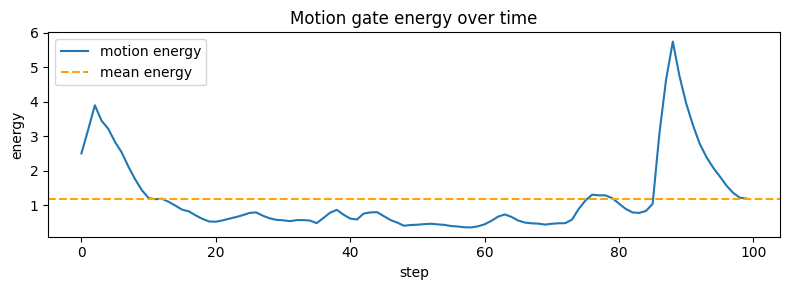

In [20]:
import matplotlib.pyplot as plt

if 'stream_result' not in globals():
    raise RuntimeError('No streaming results available; run the "Simulate streaming inference" cell first.')

energy = stream_result.get('gate_history', [])
if not energy:
    raise RuntimeError('Gate history empty; ensure the stream produced enough frames.')

plt.figure(figsize=(8, 3))
plt.plot(energy, label='motion energy')
plt.axhline(y=np.mean(energy), color='orange', linestyle='--', label='mean energy')
plt.title('Motion gate energy over time')
plt.xlabel('step')
plt.ylabel('energy')
plt.legend()
plt.tight_layout()
plt.show()


### Webcam / live capture stub
Below is a helper for testing with OpenCV if MediaPipe and a camera are available. It degrades gracefully when dependencies are missing.

In [21]:
try:
    import cv2  # type: ignore
except Exception as exc:  # pragma: no cover
    cv2 = None
    print('OpenCV not available:', exc)


def capture_webcam_stream(max_frames: int = 256, downsample: int = 2):
    """Yield normalized pose vectors from MediaPipe/OpenCV; returns empty if unavailable."""
    if cv2 is None:
        raise RuntimeError('cv2 is not installed in this environment.')

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        cap.release()
        raise RuntimeError('Could not open webcam.')

    collected = []
    try:
        frame_idx = 0
        while frame_idx < max_frames:
            ok, frame = cap.read()
            if not ok:
                break
            if frame_idx % downsample == 0:
                # Placeholder: integrate MediaPipe pose extraction here.
                pose_vec = np.zeros(INFERENCE_CFG['input_dim'], dtype=np.float32)
                collected.append(pose_vec)
            frame_idx += 1
    finally:
        cap.release()
    if not collected:
        raise RuntimeError('No frames collected; ensure MediaPipe integration fills pose_vec.')
    seq = np.stack(collected, axis=0)
    seq = normalize_with_stats(seq, GLOBAL_MEAN, GLOBAL_STD)
    return seq

In [22]:
def decode_live_camera(model: SignTranslationModel, tokenizer: SimpleTokenizer):
    if cv2 is None:
        print('cv2 missing; skipping live decode.')
        return
    try:
        seq = capture_webcam_stream()
    except RuntimeError as exc:
        print('Live capture failed:', exc)
        return
    padded = pad_to_length(seq, INFERENCE_CFG['seq_len'])
    batch = torch.from_numpy(padded).unsqueeze(0).to(DEVICE)
    decoded = beam_search_decode_batch(
        model,
        batch,
        tokenizer,
        max_len=INFERENCE_CFG['decoder_max_len'],
        beam_size=INFERENCE_CFG.get('beam_size', 1),
        length_penalty=INFERENCE_CFG.get('beam_length_penalty', 0.0)
    )
    print('Live prediction:', ids_to_sentence(decoded[0], tokenizer))

# decode_live_camera(seq2seq_model, tokenizer)  # Uncomment when pose extraction is wired up

In [23]:
if 'seq2seq_model' not in globals():
    raise RuntimeError('Model checkpoint not loaded. Run the cell that calls load_seq2seq_checkpoint first.')

decode_live_camera(seq2seq_model, tokenizer)  # Requires cv2 + MediaPipe wired up


Live capture failed: Could not open webcam.


[ WARN:0@7.345] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
